# Entrenamiento Vit

c:\Users\Frank Prime\anaconda3\envs\tf210vit\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
2400/2400 [==============================] - 69s 27ms/step - loss: 0.5029 - accuracy: 0.7527 - val_loss: 0.3538 - val_accuracy: 0.8242
Epoch 2/300
2400/2400 [==============================] - 63s 26ms/step - loss: 0.3463 - accuracy: 0.8721 - val_loss: 0.2849 - val_accuracy: 0.8892
Epoch 3/300
2400/2400 [==============================] - 64s 27ms/step - loss: 0.2932 - accuracy: 0.8931 - val_loss: 0.2528 - val_accuracy: 0.9075
Epoch 4/300
2400/2400 [==============================] - 64s 26ms/step - loss: 0.2770 - accuracy: 0.8990 - val_loss: 0.2708 - val_accuracy: 0.9125
Epoch 5/300
2400/2400 [==============================] - 64s 27ms/step - loss: 0.2501 - accuracy: 0.9167 - val_loss: 0.2574 - val_accuracy: 0.9250
Epoch 6/300
2400/2400 [==============================] - 64s 27ms/step - loss: 0.2537 - accuracy: 0.9117 - val_loss: 0.2473 - val_accuracy: 0.8992
Epoch 7/300
2400/2400 [==============================] - 64s 27ms/step - loss: 0.2420 - accuracy: 0.9073 - val_loss: 0

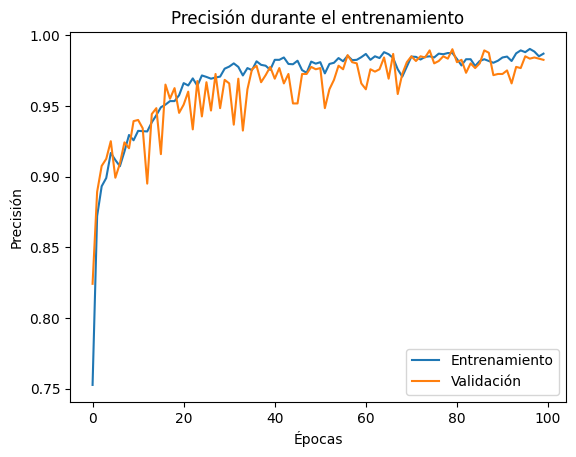

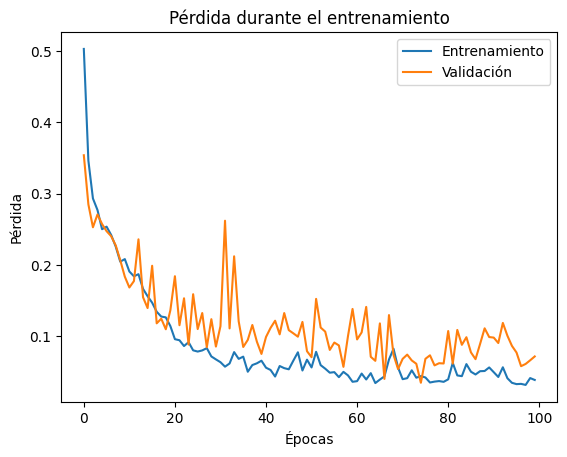

38/38 [==============================] - 2s 30ms/step


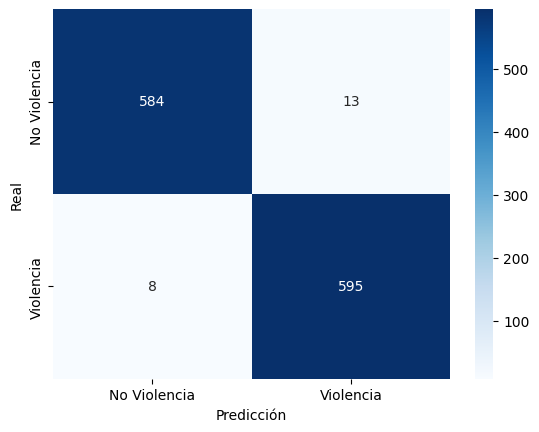

Modelo guardado como 'vit.h5' (ahora es un ViT)


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense  # dejamos Dense; ya no usamos GAP2D
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import DenseNet121  # <- YA NO SE USA
from tensorflow.keras import layers

# ------------------ CAPAS AUXILIARES PARA VISION TRANSFORMER ------------------

class PatchExtract(layers.Layer):
    """Extrae patches no superpuestos de tamaño patch_size x patch_size."""
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size  # 3 * P * P
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches  # (B, num_patches, patch_dim)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    """Proyección lineal a d_model, añade [CLS] y embedding posicional aprendible."""
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight(
            "cls", shape=(1, 1, d_model), initializer="zeros", trainable=True
        )
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )

    def call(self, patches):
        x = self.proj(patches)                      # (B, N, d_model)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)         # (B, N+1, d_model)
        return x + self.pos_emb                     # agrega posiciones

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ------------------ TUS RUTAS ------------------

# Directorios de las imágenes
ruta_violentas = "../dataset/dataset1/violencia"
ruta_no_violentas = "../dataset/dataset1/no_violencia"

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    # Convertir las listas a arrays de numpy
    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes (0 a 1)
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# ------------------ AQUI CAMBIAMOS A TRANSFORMER (ViT "tiny") ------------------

def create_model():
    # Hiperparámetros ViT
    image_size = 224
    patch_size = 16
    num_patches = (image_size // patch_size) ** 2  # 14*14=196
    d_model = 256
    num_heads = 8
    mlp_dim = 512
    num_layers = 6
    dropout = 0.1

    inputs = layers.Input(shape=(image_size, image_size, 3))

    # 1) Patch embedding + [CLS] + posiciones
    x = PatchExtract(patch_size, name="patch_extract")(inputs)      # (B, N, 3*P*P)
    x = PatchEncoder(num_patches, d_model, name="patch_encoder")(x) # (B, N+1, d_model)

    # 2) Bloques Transformer (PreNorm)
    for i in range(num_layers):
        # Atención multi-cabeza
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout, name=f"mha_{i}"
        )(x1, x1)
        x = layers.Add(name=f"skip_attn_{i}")([x, attn])

        # MLP
        x2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        mlp = layers.Dense(mlp_dim, activation=tf.keras.activations.gelu, name=f"mlp_fc1_{i}")(x2)
        mlp = layers.Dropout(dropout, name=f"mlp_do1_{i}")(mlp)
        mlp = layers.Dense(d_model, name=f"mlp_fc2_{i}")(mlp)
        mlp = layers.Dropout(dropout, name=f"mlp_do2_{i}")(mlp)
        x = layers.Add(name=f"skip_mlp_{i}")([x, mlp])

    # 3) Tomar el token [CLS] y clasificar (dos clases con softmax para tus one-hot)
    x = layers.LayerNormalization(epsilon=1e-6, name="ln_head")(x)
    cls_token = layers.Lambda(lambda t: t[:, 0], name="take_cls")(x)
    x = layers.Dense(1024, activation='relu', name="head_dense")(cls_token)
    predictions = layers.Dense(2, activation='softmax', name="pred")(x)

    model = Model(inputs=inputs, outputs=predictions, name="ViT_tiny_binary")

    # Compilar (mantenemos tu configuración de pérdida y métrica)
    model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ------------------ ENTRENAMIENTO (SIN CAMBIOS EN TU FLUJO) ------------------

def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=2):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[ 
            tf.keras.callbacks.EarlyStopping(patience=25),
            tf.keras.callbacks.ModelCheckpoint('modelo_mejorado_vit.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]
    )
    return model_history

def plot_training_history(model_history):
    # Precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Violencia', 'Violencia'],
                yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# ------------------ EJECUCIÓN (SIN CAMBIOS) ------------------

# Cargar las imágenes y etiquetas
imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)

# Dividir en conjunto de entrenamiento y validación (80% - 20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)

# Crear el modelo (ahora ViT)
model = create_model()

# Entrenar el modelo
model_history = train_model(model, X_train, y_train, X_val, y_val)

# Graficar resultados
plot_training_history(model_history)

# Matriz de confusión
plot_confusion_matrix(model, X_val, y_val)

# Guardar el modelo entrenado
model.save('vit.h5')  # puedes renombrar si quieres: 'Modelo_ViT.h5'
print("Modelo guardado como 'vit.h5' (ahora es un ViT)")


# MC Confusion

Modelo cargado: modelo_mejorado_vit.h5
Matriz de Confusión (filas = Real, columnas = Predicho):
[[1679  521]
 [ 629 1571]]


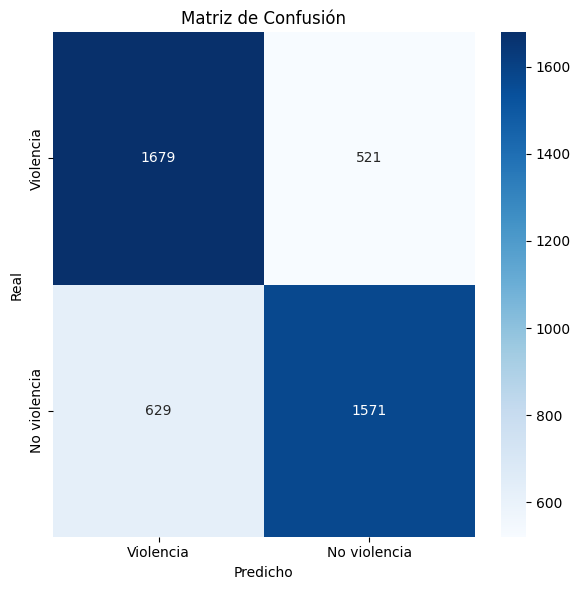


Métricas por clase:
- Violencia: precision=0.727, recall=0.763, f1=0.745
- No violencia: precision=0.751, recall=0.714, f1=0.732

Macro-average: precision=0.739, recall=0.739, f1=0.738

Classification report:

              precision    recall  f1-score   support

   Violencia       0.73      0.76      0.74      2200
No violencia       0.75      0.71      0.73      2200

    accuracy                           0.74      4400
   macro avg       0.74      0.74      0.74      4400
weighted avg       0.74      0.74      0.74      4400



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import tensorflow as tf

# ================= Capas custom necesarias para cargar el ViT =================
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ===================== Paths del test =====================
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# ===================== Carga de datos =====================
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes, etiquetas = [], []
    for filename in os.listdir(ruta_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([1, 0])  # [1,0] = Violencia -> clase 0
    for filename in os.listdir(ruta_no_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_no_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([0, 1])  # [0,1] = No violencia -> clase 1
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)
if X_test.size == 0:
    raise RuntimeError("El set de test está vacío o las rutas no contienen imágenes válidas.")

# ===================== Cargar modelo ViT =====================
customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
candidatos = ["modelo_mejorado_vit.h5", "vit.h5"]  # ajusta si usas otro nombre
modelo = None
for path in candidatos:
    if os.path.exists(path):
        modelo = load_model(path, custom_objects=customs, compile=False)
        print(f"Modelo cargado: {path}")
        break
if modelo is None:
    raise FileNotFoundError("No se encontró ninguno de: " + ", ".join(candidatos))

# ===================== Predicciones =====================
pred = modelo.predict(X_test, batch_size=32, verbose=0)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Importante: fijamos el orden de clases para que heatmap y métricas coincidan
# clase 0 = Violencia, clase 1 = No violencia
labels = [0, 1]
class_names = ["Violencia", "No violencia"]

# ===================== Matriz de confusión =====================
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Matriz de Confusión (filas = Real, columnas = Predicho):")
print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.savefig("matriz_confusion.png", dpi=150)
plt.show()

# ===================== Métricas =====================
# Por clase (0=Violencia, 1=No violencia)
prec_por_clase = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
rec_por_clase  = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
f1_por_clase   = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

print("\nMétricas por clase:")
for i, name in enumerate(class_names):
    print(f"- {name}: precision={prec_por_clase[i]:.3f}, recall={rec_por_clase[i]:.3f}, f1={f1_por_clase[i]:.3f}")

# Macro (promedio simple) para vista global
print("\nMacro-average:",
      f"precision={precision_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"recall={recall_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"f1={f1_score(y_true, y_pred, average='macro', zero_division=0):.3f}")

# Reporte completo (útil si luego cambias a más clases)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


# SubConjuntos

In [1]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras import layers
import shutil

# ===== Capas custom (necesarias si cargas el ViT) =====
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs); self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        pdim = images.shape[-1] * self.patch_size * self.patch_size
        return tf.reshape(patches, [bs, -1, pdim])
    def get_config(self):
        return {**super().get_config(), "patch_size": self.patch_size}

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight("pos_emb", shape=(1, num_patches+1, d_model),
                                       initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
                                       trainable=True)
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        return tf.concat([cls_tok, x], axis=1) + self.pos_emb
    def get_config(self):
        return {**super().get_config(), "num_patches": self.num_patches, "d_model": self.proj.units}

# ===== Config =====
IMG_SIZE = (224, 224)
RUTA_V = "../dataset/dataset22/violencia"
RUTA_NV = "../dataset/dataset22/no_violencia"

USAR_PREDICHO = True          # True = guarda por clase predicha, False = por etiqueta real
COPIAR_ARCHIVO_ORIGINAL = True # True = copia el .jpg original; False = re-guarda el array normalizado

carpetas_modelos = {
    "safe":   {"violencia": "../tipo3/safe/violencia",   "no_violencia": "../tipo3/safe/no_violencia"},
    "border": {"violencia": "../tipo3/border/violencia", "no_violencia": "../tipo3/border/no_violencia"},
    "average":{"violencia": "../tipo3/average/violencia","no_violencia": "../tipo3/average/no_violencia"},
}

# ===== Datos =====
def cargar_datos_test(ruta_violencia, ruta_no_violencia, img_size):
    imagenes, etiquetas, rutas = [], [], []
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    for ruta, label in [(ruta_violencia, [1,0]), (ruta_no_violencia, [0,1])]:
        if not os.path.isdir(ruta):
            raise FileNotFoundError(f"Directorio no encontrado: {ruta}")
        for fn in sorted(os.listdir(ruta)):
            if fn.lower().endswith(exts):
                p = os.path.join(ruta, fn)
                arr = img_to_array(load_img(p, target_size=img_size)) / 255.0
                imagenes.append(arr); etiquetas.append(label); rutas.append(p)
    X = np.asarray(imagenes, dtype="float32")
    y = np.asarray(etiquetas, dtype="int32")
    return X, y, rutas

X_test, y_test, rutas_test = cargar_datos_test(RUTA_V, RUTA_NV, IMG_SIZE)
if X_test.size == 0: raise RuntimeError("El set de test está vacío.")

# ===== Modelo (probar varios candidatos, incluyendo ViT) =====
customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
candidatos = ["modelo_mejorado_vit.h5", "vit.h5", "modelo_mejorado_Densenet.h5"]  # orden de preferencia
modelo = None; ultimo_error = None
for path in candidatos:
    if os.path.exists(path):
        try:
            modelo = load_model(path, custom_objects=customs, compile=False)
            print(f"Modelo cargado: {path}"); break
        except Exception as e:
            ultimo_error = e
if modelo is None:
    raise FileNotFoundError(f"No se pudo cargar modelo. Intentado: {candidatos}\nÚltimo error: {ultimo_error}")

# ===== Predicción robusta (softmax 2 clases o sigmoid 1 clase) =====
raw = modelo.predict(X_test, batch_size=32, verbose=0)
raw = np.asarray(raw)
if raw.ndim == 2 and raw.shape[1] == 2:
    # Entrenaste con one-hot: clase 0 = Violencia, clase 1 = No violencia
    p_violencia = raw[:, 0]
elif raw.ndim in (1,2) and raw.shape[-1] == 1:
    # Modelo binario sigmoid que devuelve p(violencia)
    p_violencia = raw.reshape(-1)
else:
    raise ValueError(f"Salida de modelo no esperada: shape={raw.shape}")

# Etiquetas reales y predichas (0=Violencia, 1=No violencia)
y_true = np.argmax(y_test, axis=1)
y_pred = (p_violencia < 0.5).astype(int)  # si p_violencia>=0.5 => clase 0 (violencia), si <0.5 => 1 (no violencia)

# ===== Selección de muestras =====
def seleccionar_muestras(prob_violencia, tipo):
    media = float(np.mean(prob_violencia)); std = float(np.std(prob_violencia))
    if tipo == "safe":
        lo, hi = 0.1, 0.9
        idx = np.where((prob_violencia <= lo) | (prob_violencia >= hi))[0]
        print(f"\n--- {tipo} --- Umbrales: <= {lo:.2f} o >= {hi:.2f} (alta certeza)")
    elif tipo == "border":
        lo, hi = 0.4, 0.6
        idx = np.where((prob_violencia >= lo) & (prob_violencia <= hi))[0]
        print(f"\n--- {tipo} --- Umbrales: {lo:.2f}–{hi:.2f} (zona ambigua)")
    else:  # "average"
        lo, hi = max(0.0, media - std), min(1.0, media + std)
        idx = np.where((prob_violencia >= lo) & (prob_violencia <= hi))[0]
        print(f"\n--- {tipo} --- Umbrales: {lo:.3f}–{hi:.3f} (media ± std)")
    print(f"Nº muestras seleccionadas: {len(idx)}")
    return idx

# ===== Guardado =====
def asegurar_dir(path):
    os.makedirs(path, exist_ok=True)

def guardar_imagen(indice, destino_dir):
    asegurar_dir(destino_dir)
    nombre = os.path.basename(rutas_test[indice])
    destino = os.path.join(destino_dir, f"representativa_{indice}__{nombre}")
    if COPIAR_ARCHIVO_ORIGINAL:
        shutil.copy2(rutas_test[indice], destino)
    else:
        arr = (np.clip(X_test[indice], 0, 1) * 255).astype(np.uint8)
        save_img(destino, arr)
    return destino

for tipo_muestra in ["safe", "border", "average"]:
    idx_sel = seleccionar_muestras(p_violencia, tipo_muestra)
    for i, idx in enumerate(idx_sel):
        if USAR_PREDICHO:
            clase = "violencia" if y_pred[idx] == 0 else "no_violencia"
        else:
            clase = "violencia" if y_true[idx] == 0 else "no_violencia"
        destino_dir = carpetas_modelos[tipo_muestra][clase]
        guardar_imagen(idx, destino_dir)

# ===== Resumen =====
print("\n--- Resumen de imágenes guardadas ---")
for tipo_muestra, rutas in carpetas_modelos.items():
    for categoria, ruta in rutas.items():
        n = sum(f.lower().endswith(".jpg") or f.lower().endswith(".jpeg") or f.lower().endswith(".png")
                for f in os.listdir(ruta)) if os.path.exists(ruta) else 0
        print(f"{tipo_muestra} - {categoria}: {n} imágenes")

print("\nProceso completado.")


Modelo cargado: modelo_mejorado_vit.h5

--- safe --- Umbrales: <= 0.10 o >= 0.90 (alta certeza)
Nº muestras seleccionadas: 2815

--- border --- Umbrales: 0.40–0.60 (zona ambigua)
Nº muestras seleccionadas: 733

--- average --- Umbrales: 0.186–0.933 (media ± std)
Nº muestras seleccionadas: 2609

--- Resumen de imágenes guardadas ---
safe - violencia: 1753 imágenes
safe - no_violencia: 1062 imágenes
border - violencia: 332 imágenes
border - no_violencia: 401 imágenes
average - violencia: 1484 imágenes
average - no_violencia: 1125 imágenes

Proceso completado.


# AVERAGE

Modelo cargado desde: modelo_mejorado_vit.h5
Epoch 1/300
1044/1044 [==============================] - 40s 34ms/step - loss: 0.5524 - accuracy: 0.7575 - val_loss: 0.4009 - val_accuracy: 0.8123
Epoch 2/300
1044/1044 [==============================] - 34s 32ms/step - loss: 0.5179 - accuracy: 0.7839 - val_loss: 0.3522 - val_accuracy: 0.8659
Epoch 3/300
1044/1044 [==============================] - 33s 32ms/step - loss: 0.4533 - accuracy: 0.7911 - val_loss: 0.3669 - val_accuracy: 0.8487
Epoch 4/300
1044/1044 [==============================] - 33s 32ms/step - loss: 0.4105 - accuracy: 0.8103 - val_loss: 0.3141 - val_accuracy: 0.8889
Epoch 5/300
1044/1044 [==============================] - 33s 32ms/step - loss: 0.3988 - accuracy: 0.8179 - val_loss: 0.3197 - val_accuracy: 0.8793
Epoch 6/300
1044/1044 [==============================] - 33s 31ms/step - loss: 0.3842 - accuracy: 0.8232 - val_loss: 0.3296 - val_accuracy: 0.8697
Epoch 7/300
1044/1044 [==============================] - 41s 39ms/step - 

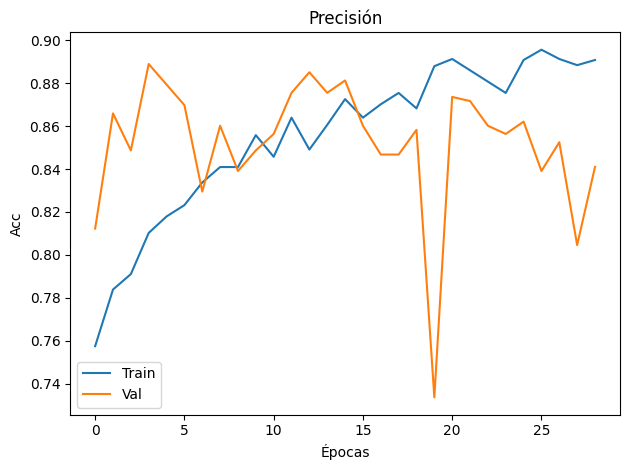

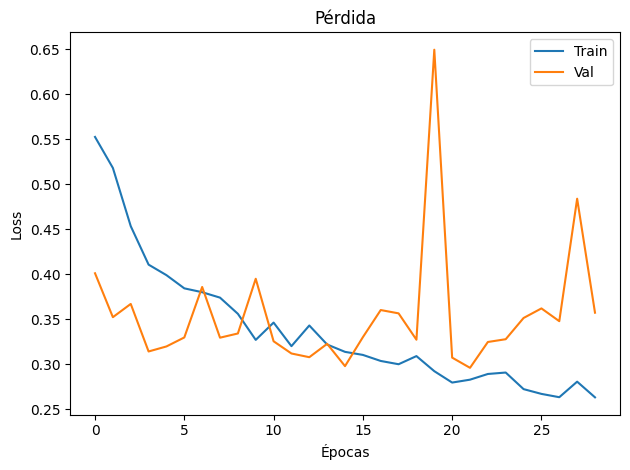

Precisión en validación: 0.8889


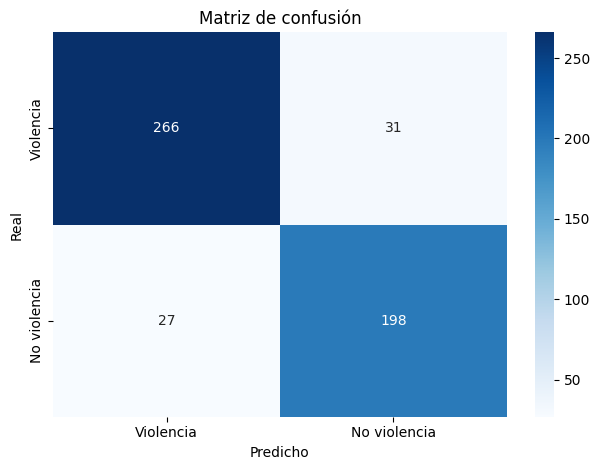

Modelo final guardado como 'Modelo_average_vit.h5'.


In [2]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ------------------ Semilla ------------------
np.random.seed(1337)
tf.random.set_seed(1337)

# ------------------ Capas ViT (custom) ------------------
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs); self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        return tf.reshape(patches, [bs, -1, patch_dim])
    def get_config(self):
        return {**super().get_config(), "patch_size": self.patch_size}

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06), trainable=True
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        return {**super().get_config(), "num_patches": self.num_patches, "d_model": self.proj.units}

# ------------------ Datos ------------------
def load_images_and_labels(ruta_violentas, ruta_no_violentas, img_size=(224,224)):
    imagenes, etiquetas = [], []
    for filename in sorted(os.listdir(ruta_violentas)):
        if filename.lower().endswith(".jpg"):
            img = tf.keras.preprocessing.image.load_img(os.path.join(ruta_violentas, filename), target_size=img_size)
            imagenes.append(tf.keras.preprocessing.image.img_to_array(img))
            etiquetas.append([1, 0])  # 0 = Violencia
    for filename in sorted(os.listdir(ruta_no_violentas)):
        if filename.lower().endswith(".jpg"):
            img = tf.keras.preprocessing.image.load_img(os.path.join(ruta_no_violentas, filename), target_size=img_size)
            imagenes.append(tf.keras.preprocessing.image.img_to_array(img))
            etiquetas.append([0, 1])  # 1 = No violencia
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

# ------------------ Crear ViT (fallback si no hay .h5) ------------------
def create_vit_tiny(image_size=224, patch_size=16, d_model=256, num_heads=8, mlp_dim=512, num_layers=6, dropout=0.1):
    num_patches = (image_size // patch_size) ** 2
    inputs = layers.Input(shape=(image_size, image_size, 3))
    x = PatchExtract(patch_size, name="patch_extract")(inputs)
    x = PatchEncoder(num_patches, d_model, name="patch_encoder")(x)
    for i in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads,
                                         dropout=dropout, name=f"mha_{i}")(x1, x1)
        x = layers.Add(name=f"skip_attn_{i}")([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        mlp = layers.Dense(mlp_dim, activation=tf.keras.activations.gelu, name=f"mlp_fc1_{i}")(x2)
        mlp = layers.Dropout(dropout, name=f"mlp_do1_{i}")(mlp)
        mlp = layers.Dense(d_model, name=f"mlp_fc2_{i}")(mlp)
        mlp = layers.Dropout(dropout, name=f"mlp_do2_{i}")(mlp)
        x = layers.Add(name=f"skip_mlp_{i}")([x, mlp])
    x = layers.LayerNormalization(epsilon=1e-6, name="ln_head")(x)
    cls_token = layers.Lambda(lambda t: t[:, 0], name="take_cls")(x)
    x = layers.Dense(1024, activation='relu', name="head_dense")(cls_token)
    outputs = layers.Dense(2, activation='softmax', name="pred")(x)
    model = Model(inputs=inputs, outputs=outputs, name="ViT_tiny_binary")
    return model

# ------------------ Cargar o crear (usa tu ViT) ------------------
def load_or_create_model(model_path=None, lr=1e-4):
    customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
    candidatos = [model_path] if model_path else ["modelo_mejorado_vit.h5", "vit.h5"]
    model = None
    for p in [c for c in candidatos if c]:
        if os.path.exists(p):
            model = load_model(p, custom_objects=customs, compile=False)
            print(f"Modelo cargado desde: {p}")
            break
    if model is None:
        print("No se encontró .h5 de ViT; se crea ViT tiny nuevo.")
        model = create_vit_tiny()
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ------------------ Entrenamiento ------------------
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=2):
    cb = [
        tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True, monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.ModelCheckpoint('modelo_finetuned_average_vit.h5', save_best_only=True,
                                           monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]
    hist = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=cb,
        verbose=1
    )
    return hist

# ------------------ Plots ------------------
def plot_training_history(model_history):
    plt.figure(); plt.plot(model_history.history['accuracy']); plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión'); plt.xlabel('Épocas'); plt.ylabel('Acc'); plt.legend(['Train','Val']); plt.tight_layout(); plt.show()
    plt.figure(); plt.plot(model_history.history['loss']); plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida'); plt.xlabel('Épocas'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.tight_layout(); plt.show()

def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # 0=Violencia, 1=No violencia
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Violencia','No violencia'],
                yticklabels=['Violencia','No violencia'])
    plt.xlabel('Predicho'); plt.ylabel('Real'); plt.title('Matriz de confusión'); plt.tight_layout(); plt.show()

def evaluate_model(model, X_val, y_val):
    test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Precisión en validación: {test_acc:.4f}")
    return test_acc

# ------------------ Pipeline ------------------
def run_pipeline(ruta_violentas, ruta_no_violentas, model_path=None, epochs=300, batch_size=2, lr=1e-4):
    X, y = load_images_and_labels(ruta_violentas, ruta_no_violentas, img_size=(224,224))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
    model = load_or_create_model(model_path, lr=lr)
    hist = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    plot_training_history(hist)
    evaluate_model(model, X_val, y_val)
    plot_confusion_matrix(model, X_val, y_val)
    model.save('Modelo_average_vit.h5')
    print("Modelo final guardado como 'Modelo_average_vit.h5'.")

# -------- Ejecución (usa tus carpetas average y tu ViT) --------
run_pipeline(
    ruta_violentas="../tipo3/average/violencia",
    ruta_no_violentas="../tipo3/average/no_violencia",
    model_path="modelo_mejorado_vit.h5",   # o "vit.h5" si prefieres el último
    epochs=300,
    batch_size=2,
    lr=1e-4
)


Modelo cargado: modelo_finetuned_average_vit.h5
Matriz de Confusión (filas = Real, columnas = Predicho):
[[1673  527]
 [ 616 1584]]


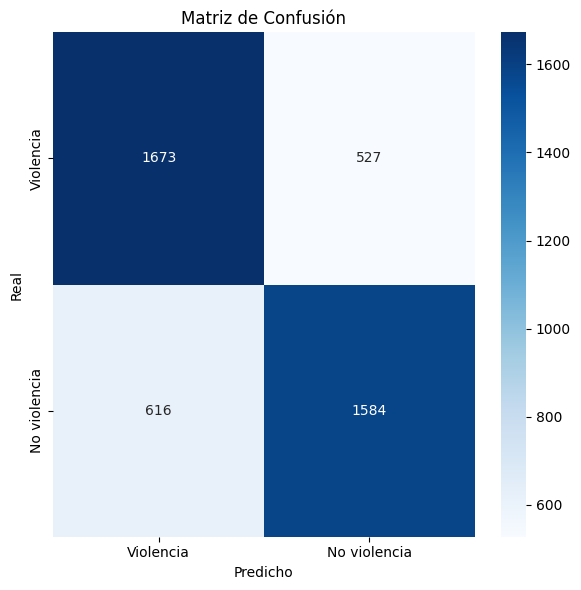


Métricas por clase:
- Violencia: precision=0.731, recall=0.760, f1=0.745
- No violencia: precision=0.750, recall=0.720, f1=0.735

Macro-average: precision=0.741, recall=0.740, f1=0.740

Classification report:

              precision    recall  f1-score   support

   Violencia       0.73      0.76      0.75      2200
No violencia       0.75      0.72      0.73      2200

    accuracy                           0.74      4400
   macro avg       0.74      0.74      0.74      4400
weighted avg       0.74      0.74      0.74      4400



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import tensorflow as tf

# ================= Capas custom necesarias para cargar el ViT =================
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ===================== Paths del test =====================
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# ===================== Carga de datos =====================
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes, etiquetas = [], []
    for filename in os.listdir(ruta_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([1, 0])  # [1,0] = Violencia -> clase 0
    for filename in os.listdir(ruta_no_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_no_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([0, 1])  # [0,1] = No violencia -> clase 1
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)
if X_test.size == 0:
    raise RuntimeError("El set de test está vacío o las rutas no contienen imágenes válidas.")

# ===================== Cargar modelo ViT =====================
customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
candidatos = ["modelo_finetuned_average_vit.h5", "Modelo_average_vit.h5"]  # ajusta si usas otro nombre
modelo = None
for path in candidatos:
    if os.path.exists(path):
        modelo = load_model(path, custom_objects=customs, compile=False)
        print(f"Modelo cargado: {path}")
        break
if modelo is None:
    raise FileNotFoundError("No se encontró ninguno de: " + ", ".join(candidatos))

# ===================== Predicciones =====================
pred = modelo.predict(X_test, batch_size=32, verbose=0)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Importante: fijamos el orden de clases para que heatmap y métricas coincidan
# clase 0 = Violencia, clase 1 = No violencia
labels = [0, 1]
class_names = ["Violencia", "No violencia"]

# ===================== Matriz de confusión =====================
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Matriz de Confusión (filas = Real, columnas = Predicho):")
print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.savefig("matriz_confusion.png", dpi=150)
plt.show()

# ===================== Métricas =====================
# Por clase (0=Violencia, 1=No violencia)
prec_por_clase = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
rec_por_clase  = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
f1_por_clase   = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

print("\nMétricas por clase:")
for i, name in enumerate(class_names):
    print(f"- {name}: precision={prec_por_clase[i]:.3f}, recall={rec_por_clase[i]:.3f}, f1={f1_por_clase[i]:.3f}")

# Macro (promedio simple) para vista global
print("\nMacro-average:",
      f"precision={precision_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"recall={recall_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"f1={f1_score(y_true, y_pred, average='macro', zero_division=0):.3f}")

# Reporte completo (útil si luego cambias a más clases)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


# BORDER

Modelo cargado desde: modelo_mejorado_vit.h5
Epoch 1/1000
19/19 [==============================] - 8s 141ms/step - loss: 0.7509 - accuracy: 0.5802 - val_loss: 0.6882 - val_accuracy: 0.4626
Epoch 2/1000
19/19 [==============================] - 2s 109ms/step - loss: 0.7444 - accuracy: 0.6314 - val_loss: 0.6202 - val_accuracy: 0.6463
Epoch 3/1000
19/19 [==============================] - 2s 91ms/step - loss: 0.6877 - accuracy: 0.6382 - val_loss: 0.6642 - val_accuracy: 0.4762
Epoch 4/1000
19/19 [==============================] - 2s 92ms/step - loss: 0.6933 - accuracy: 0.6092 - val_loss: 0.6766 - val_accuracy: 0.4694
Epoch 5/1000
19/19 [==============================] - 2s 92ms/step - loss: 0.6911 - accuracy: 0.6416 - val_loss: 0.6562 - val_accuracy: 0.4898
Epoch 6/1000
19/19 [==============================] - 2s 91ms/step - loss: 0.6536 - accuracy: 0.6638 - val_loss: 0.6672 - val_accuracy: 0.4966
Epoch 7/1000
19/19 [==============================] - 2s 92ms/step - loss: 0.6669 - accuracy: 0

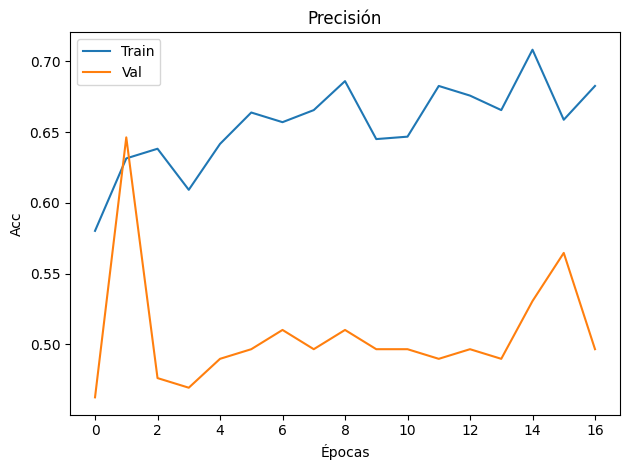

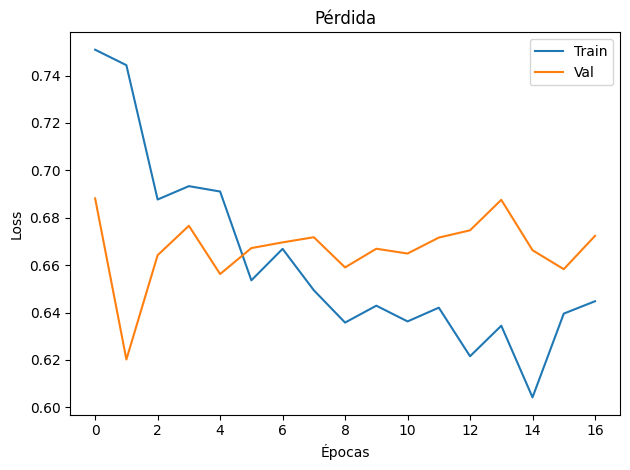

Precisión en validación: 0.6463


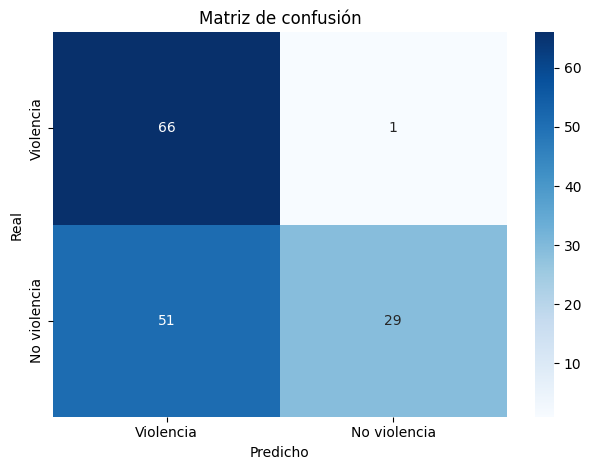

Modelo final guardado como 'Modelo_border_vit.h5'.


In [4]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ------------------ Semillas ------------------
np.random.seed(1337)
tf.random.set_seed(1337)

# ------------------ Capas ViT (custom) ------------------
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs); self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        return tf.reshape(patches, [bs, -1, patch_dim])
    def get_config(self):
        return {**super().get_config(), "patch_size": self.patch_size}

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06), trainable=True
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        return {**super().get_config(), "num_patches": self.num_patches, "d_model": self.proj.units}

# ------------------ Datos ------------------
def load_images_and_labels(ruta_violentas, ruta_no_violentas, img_size=(224,224)):
    imagenes, etiquetas = [], []
    exts = (".jpg", ".jpeg", ".png")
    for filename in sorted(os.listdir(ruta_violentas)):
        if filename.lower().endswith(exts):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=img_size
            )
            imagenes.append(tf.keras.preprocessing.image.img_to_array(img))
            etiquetas.append([1, 0])  # 0 = Violencia
    for filename in sorted(os.listdir(ruta_no_violentas)):
        if filename.lower().endswith(exts):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=img_size
            )
            imagenes.append(tf.keras.preprocessing.image.img_to_array(img))
            etiquetas.append([0, 1])  # 1 = No violencia
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

# ------------------ ViT tiny (fallback) ------------------
def create_vit_tiny(image_size=224, patch_size=16, d_model=256, num_heads=8, mlp_dim=512, num_layers=6, dropout=0.1):
    num_patches = (image_size // patch_size) ** 2
    inputs = layers.Input(shape=(image_size, image_size, 3))
    x = PatchExtract(patch_size, name="patch_extract")(inputs)
    x = PatchEncoder(num_patches, d_model, name="patch_encoder")(x)
    for i in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads,
                                         dropout=dropout, name=f"mha_{i}")(x1, x1)
        x = layers.Add(name=f"skip_attn_{i}")([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        mlp = layers.Dense(mlp_dim, activation=tf.keras.activations.gelu, name=f"mlp_fc1_{i}")(x2)
        mlp = layers.Dropout(dropout, name=f"mlp_do1_{i}")(mlp)
        mlp = layers.Dense(d_model, name=f"mlp_fc2_{i}")(mlp)
        mlp = layers.Dropout(dropout, name=f"mlp_do2_{i}")(mlp)
        x = layers.Add(name=f"skip_mlp_{i}")([x, mlp])
    x = layers.LayerNormalization(epsilon=1e-6, name="ln_head")(x)
    cls_token = layers.Lambda(lambda t: t[:, 0], name="take_cls")(x)
    x = layers.Dense(1024, activation='relu', name="head_dense")(cls_token)
    outputs = layers.Dense(2, activation='softmax', name="pred")(x)
    return Model(inputs, outputs, name="ViT_tiny_binary")

# ------------------ Cargar o crear (usa tu ViT) ------------------
def load_or_create_model(model_path=None, lr=1e-4):
    customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
    candidatos = [model_path] if model_path else ["modelo_mejorado_vit.h5", "vit.h5"]
    model = None
    for p in [c for c in candidatos if c]:
        if os.path.exists(p):
            model = load_model(p, custom_objects=customs, compile=False)
            print(f"Modelo cargado desde: {p}")
            break
    if model is None:
        print("No se encontró .h5; se crea ViT tiny nuevo.")
        model = create_vit_tiny()
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ------------------ Entrenamiento ------------------
def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32):
    cbs = [
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.ModelCheckpoint('modelo_finetuned_border_vit.h5', save_best_only=True,
                                           monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=cbs,
        verbose=1
    )

# ------------------ Plots ------------------
def plot_training_history(model_history):
    plt.figure(); plt.plot(model_history.history['accuracy']); plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión'); plt.xlabel('Épocas'); plt.ylabel('Acc'); plt.legend(['Train','Val']); plt.tight_layout(); plt.show()
    plt.figure(); plt.plot(model_history.history['loss']); plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida'); plt.xlabel('Épocas'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.tight_layout(); plt.show()

def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # 0=Violencia, 1=No violencia
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Violencia','No violencia'],
                yticklabels=['Violencia','No violencia'])
    plt.xlabel('Predicho'); plt.ylabel('Real'); plt.title('Matriz de confusión'); plt.tight_layout(); plt.show()

def evaluate_model(model, X_val, y_val):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Precisión en validación: {acc:.4f}")
    return acc

# ------------------ Pipeline ------------------
def run_pipeline(ruta_violentas, ruta_no_violentas, model_path=None, epochs=1000, batch_size=2, lr=1e-4):
    X, y = load_images_and_labels(ruta_violentas, ruta_no_violentas, img_size=(224,224))
    y_strat = np.argmax(y, axis=1)  # estratificación correcta
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y_strat)
    model = load_or_create_model(model_path, lr=lr)
    hist = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    plot_training_history(hist)
    evaluate_model(model, X_val, y_val)
    plot_confusion_matrix(model, X_val, y_val)
    model.save('Modelo_border_vit.h5')
    print("Modelo final guardado como 'Modelo_border_vit.h5'.")

# ------------------ Ejecución ------------------
run_pipeline(
    ruta_violentas="../tipo3/border/violencia",
    ruta_no_violentas="../tipo3/border/no_violencia",
    model_path="modelo_mejorado_vit.h5",  # usa tu ViT (.h5); si no existe, crea uno nuevo
    epochs=1000,
    batch_size=32,
    lr=1e-4
)


Modelo cargado: modelo_finetuned_border_vit.h5
Matriz de Confusión (filas = Real, columnas = Predicho):
[[1722  478]
 [ 672 1528]]


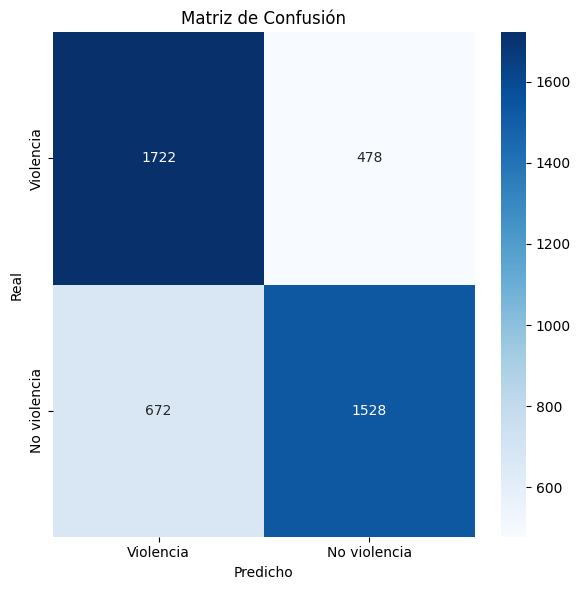


Métricas por clase:
- Violencia: precision=0.719, recall=0.783, f1=0.750
- No violencia: precision=0.762, recall=0.695, f1=0.727

Macro-average: precision=0.741, recall=0.739, f1=0.738

Classification report:

              precision    recall  f1-score   support

   Violencia       0.72      0.78      0.75      2200
No violencia       0.76      0.69      0.73      2200

    accuracy                           0.74      4400
   macro avg       0.74      0.74      0.74      4400
weighted avg       0.74      0.74      0.74      4400



In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import tensorflow as tf

# ================= Capas custom necesarias para cargar el ViT =================
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ===================== Paths del test =====================
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# ===================== Carga de datos =====================
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes, etiquetas = [], []
    for filename in os.listdir(ruta_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([1, 0])  # [1,0] = Violencia -> clase 0
    for filename in os.listdir(ruta_no_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_no_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([0, 1])  # [0,1] = No violencia -> clase 1
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)
if X_test.size == 0:
    raise RuntimeError("El set de test está vacío o las rutas no contienen imágenes válidas.")

# ===================== Cargar modelo ViT =====================
customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
candidatos = ["modelo_finetuned_border_vit.h5", "Modelo_border_vit.h5"]  # ajusta si usas otro nombre
modelo = None
for path in candidatos:
    if os.path.exists(path):
        modelo = load_model(path, custom_objects=customs, compile=False)
        print(f"Modelo cargado: {path}")
        break
if modelo is None:
    raise FileNotFoundError("No se encontró ninguno de: " + ", ".join(candidatos))

# ===================== Predicciones =====================
pred = modelo.predict(X_test, batch_size=32, verbose=0)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Importante: fijamos el orden de clases para que heatmap y métricas coincidan
# clase 0 = Violencia, clase 1 = No violencia
labels = [0, 1]
class_names = ["Violencia", "No violencia"]

# ===================== Matriz de confusión =====================
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Matriz de Confusión (filas = Real, columnas = Predicho):")
print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.savefig("matriz_confusion.png", dpi=150)
plt.show()

# ===================== Métricas =====================
# Por clase (0=Violencia, 1=No violencia)
prec_por_clase = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
rec_por_clase  = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
f1_por_clase   = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

print("\nMétricas por clase:")
for i, name in enumerate(class_names):
    print(f"- {name}: precision={prec_por_clase[i]:.3f}, recall={rec_por_clase[i]:.3f}, f1={f1_por_clase[i]:.3f}")

# Macro (promedio simple) para vista global
print("\nMacro-average:",
      f"precision={precision_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"recall={recall_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"f1={f1_score(y_true, y_pred, average='macro', zero_division=0):.3f}")

# Reporte completo (útil si luego cambias a más clases)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


# SAFE

Modelo cargado desde: modelo_mejorado_vit.h5
Epoch 1/300
1126/1126 [==============================] - 35s 27ms/step - loss: 0.1392 - accuracy: 0.9618 - val_loss: 0.1379 - val_accuracy: 0.9591
Epoch 2/300
1126/1126 [==============================] - 27s 24ms/step - loss: 0.1263 - accuracy: 0.9560 - val_loss: 0.1915 - val_accuracy: 0.9396
Epoch 3/300
1126/1126 [==============================] - 30s 26ms/step - loss: 0.1559 - accuracy: 0.9383 - val_loss: 0.1256 - val_accuracy: 0.9556
Epoch 4/300
1126/1126 [==============================] - 28s 25ms/step - loss: 0.1293 - accuracy: 0.9529 - val_loss: 0.1193 - val_accuracy: 0.9538
Epoch 5/300
1126/1126 [==============================] - 32s 28ms/step - loss: 0.1147 - accuracy: 0.9498 - val_loss: 0.1045 - val_accuracy: 0.9485
Epoch 6/300
1126/1126 [==============================] - 32s 28ms/step - loss: 0.1158 - accuracy: 0.9547 - val_loss: 0.0984 - val_accuracy: 0.9520
Epoch 7/300
1126/1126 [==============================] - 30s 27ms/step - 

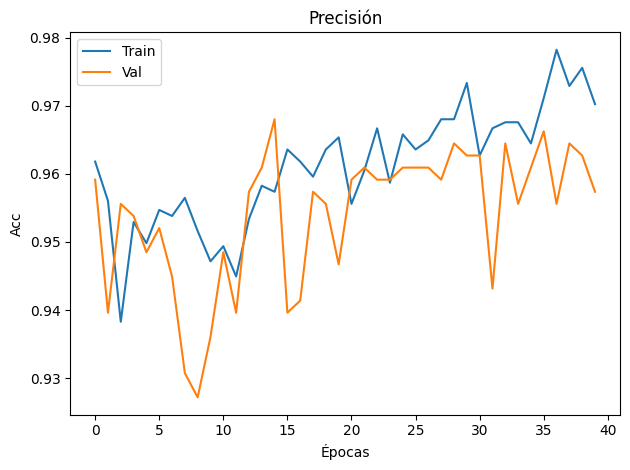

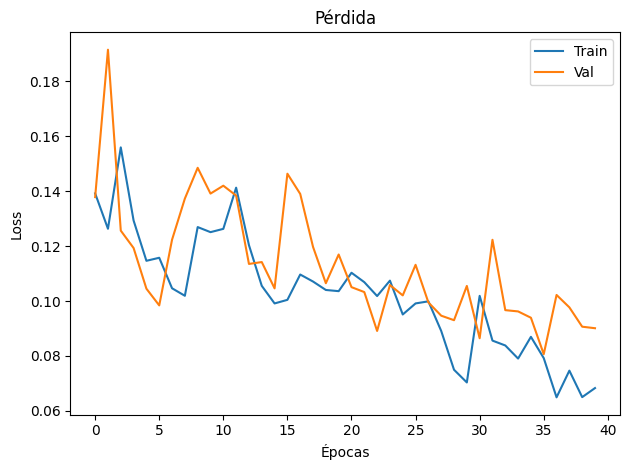

Precisión en validación: 0.9680


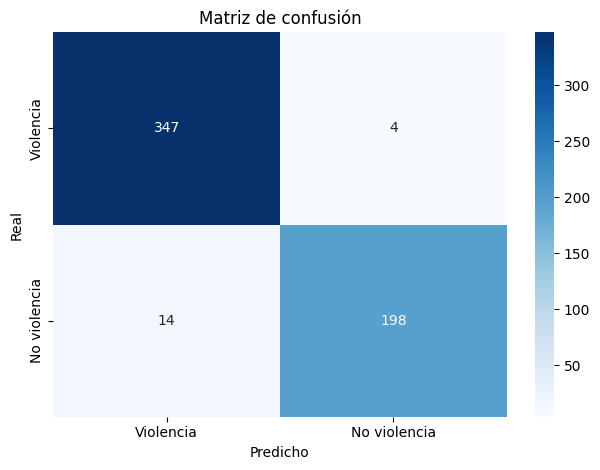

Modelo final guardado como 'Modelo_safe_vit.h5'.


In [1]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ---- Semillas ----
np.random.seed(1337)
tf.random.set_seed(1337)

# ---- Capas ViT (custom) ----
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs); self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        return tf.reshape(patches, [bs, -1, patch_dim])
    def get_config(self):
        return {**super().get_config(), "patch_size": self.patch_size}

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06), trainable=True
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        return {**super().get_config(), "num_patches": self.num_patches, "d_model": self.proj.units}

# ---- Datos ----
def load_images_and_labels(ruta_violentas, ruta_no_violentas, img_size=(224,224)):
    imagenes, etiquetas = [], []
    exts = (".jpg", ".jpeg", ".png")
    for filename in sorted(os.listdir(ruta_violentas)):
        if filename.lower().endswith(exts):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=img_size
            )
            imagenes.append(tf.keras.preprocessing.image.img_to_array(img))
            etiquetas.append([1, 0])  # 0 = Violencia
    for filename in sorted(os.listdir(ruta_no_violentas)):
        if filename.lower().endswith(exts):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=img_size
            )
            imagenes.append(tf.keras.preprocessing.image.img_to_array(img))
            etiquetas.append([0, 1])  # 1 = No violencia
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

# ---- ViT tiny (fallback) ----
def create_vit_tiny(image_size=224, patch_size=16, d_model=256, num_heads=8, mlp_dim=512, num_layers=6, dropout=0.1):
    num_patches = (image_size // patch_size) ** 2
    inputs = layers.Input(shape=(image_size, image_size, 3))
    x = PatchExtract(patch_size, name="patch_extract")(inputs)
    x = PatchEncoder(num_patches, d_model, name="patch_encoder")(x)
    for i in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads,
                                         dropout=dropout, name=f"mha_{i}")(x1, x1)
        x = layers.Add(name=f"skip_attn_{i}")([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        mlp = layers.Dense(mlp_dim, activation=tf.keras.activations.gelu, name=f"mlp_fc1_{i}")(x2)
        mlp = layers.Dropout(dropout, name=f"mlp_do1_{i}")(mlp)
        mlp = layers.Dense(d_model, name=f"mlp_fc2_{i}")(mlp)
        mlp = layers.Dropout(dropout, name=f"mlp_do2_{i}")(mlp)
        x = layers.Add(name=f"skip_mlp_{i}")([x, mlp])
    x = layers.LayerNormalization(epsilon=1e-6, name="ln_head")(x)
    cls = layers.Lambda(lambda t: t[:, 0], name="take_cls")(x)
    x = layers.Dense(1024, activation='relu', name="head_dense")(cls)
    outputs = layers.Dense(2, activation='softmax', name="pred")(x)
    return Model(inputs, outputs, name="ViT_tiny_binary")

# ---- Cargar o crear (usa tu ViT) ----
def load_or_create_model(model_path=None, lr=1e-4):
    customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
    candidatos = [model_path] if model_path else ["modelo_mejorado_vit.h5", "vit.h5"]
    model = None
    for p in [c for c in candidatos if c]:
        if os.path.exists(p):
            model = load_model(p, custom_objects=customs, compile=False)
            print(f"Modelo cargado desde: {p}")
            break
    if model is None:
        print("No se encontró .h5; se crea ViT tiny nuevo.")
        model = create_vit_tiny()
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ---- Entrenamiento ----
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=2):
    cbs = [
        tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True,
                                         monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.ModelCheckpoint('modelo_finetuned_safe_vit.h5', save_best_only=True,
                                           monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=cbs,
        verbose=1
    )

# ---- Plots ----
def plot_training_history(model_history):
    plt.figure(); plt.plot(model_history.history['accuracy']); plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión'); plt.xlabel('Épocas'); plt.ylabel('Acc'); plt.legend(['Train','Val']); plt.tight_layout(); plt.show()
    plt.figure(); plt.plot(model_history.history['loss']); plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida'); plt.xlabel('Épocas'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.tight_layout(); plt.show()

def plot_confusion_matrix_vit(model, X_val, y_val):
    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # 0=Violencia, 1=No violencia
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Violencia','No violencia'],
                yticklabels=['Violencia','No violencia'])
    plt.xlabel('Predicho'); plt.ylabel('Real'); plt.title('Matriz de confusión'); plt.tight_layout(); plt.show()

def evaluate_model(model, X_val, y_val):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Precisión en validación: {acc:.4f}")
    return acc

# ---- Pipeline ----
def run_pipeline(ruta_violentas, ruta_no_violentas, model_path=None, epochs=300, batch_size=2, lr=1e-4):
    X, y = load_images_and_labels(ruta_violentas, ruta_no_violentas, img_size=(224,224))
    y_strat = np.argmax(y, axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y_strat)
    model = load_or_create_model(model_path, lr=lr)
    hist = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    plot_training_history(hist)
    evaluate_model(model, X_val, y_val)
    plot_confusion_matrix_vit(model, X_val, y_val)
    model.save('Modelo_safe_vit.h5')
    print("Modelo final guardado como 'Modelo_safe_vit.h5'.")

# ---- Ejecución ----
run_pipeline(
    ruta_violentas="../tipo3/safe/violencia",
    ruta_no_violentas="../tipo3/safe/no_violencia",
    model_path="modelo_mejorado_vit.h5",  # o "vit.h5"
    epochs=300,
    batch_size=2,
    lr=1e-4
)


Modelo cargado: modelo_finetuned_safe_vit.h5
Matriz de Confusión (filas = Real, columnas = Predicho):
[[1827  373]
 [ 814 1386]]


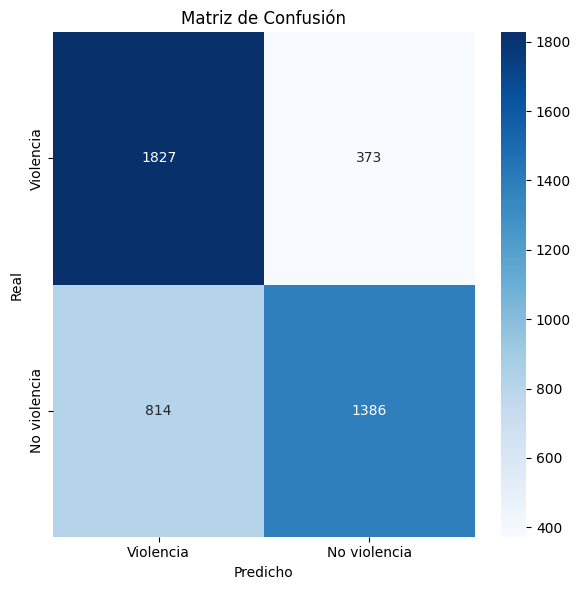


Métricas por clase:
- Violencia: precision=0.692, recall=0.830, f1=0.755
- No violencia: precision=0.788, recall=0.630, f1=0.700

Macro-average: precision=0.740, recall=0.730, f1=0.727

Classification report:

              precision    recall  f1-score   support

   Violencia       0.69      0.83      0.75      2200
No violencia       0.79      0.63      0.70      2200

    accuracy                           0.73      4400
   macro avg       0.74      0.73      0.73      4400
weighted avg       0.74      0.73      0.73      4400



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import tensorflow as tf

# ================= Capas custom necesarias para cargar el ViT =================
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ===================== Paths del test =====================
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# ===================== Carga de datos =====================
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes, etiquetas = [], []
    for filename in os.listdir(ruta_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([1, 0])  # [1,0] = Violencia -> clase 0
    for filename in os.listdir(ruta_no_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_no_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([0, 1])  # [0,1] = No violencia -> clase 1
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)
if X_test.size == 0:
    raise RuntimeError("El set de test está vacío o las rutas no contienen imágenes válidas.")

# ===================== Cargar modelo ViT =====================
customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
candidatos = ["modelo_finetuned_safe_vit.h5", "Modelo_safe_vit.h5"]  # ajusta si usas otro nombre
modelo = None
for path in candidatos:
    if os.path.exists(path):
        modelo = load_model(path, custom_objects=customs, compile=False)
        print(f"Modelo cargado: {path}")
        break
if modelo is None:
    raise FileNotFoundError("No se encontró ninguno de: " + ", ".join(candidatos))

# ===================== Predicciones =====================
pred = modelo.predict(X_test, batch_size=32, verbose=0)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Importante: fijamos el orden de clases para que heatmap y métricas coincidan
# clase 0 = Violencia, clase 1 = No violencia
labels = [0, 1]
class_names = ["Violencia", "No violencia"]

# ===================== Matriz de confusión =====================
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Matriz de Confusión (filas = Real, columnas = Predicho):")
print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.savefig("matriz_confusion.png", dpi=150)
plt.show()

# ===================== Métricas =====================
# Por clase (0=Violencia, 1=No violencia)
prec_por_clase = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
rec_por_clase  = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
f1_por_clase   = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

print("\nMétricas por clase:")
for i, name in enumerate(class_names):
    print(f"- {name}: precision={prec_por_clase[i]:.3f}, recall={rec_por_clase[i]:.3f}, f1={f1_por_clase[i]:.3f}")

# Macro (promedio simple) para vista global
print("\nMacro-average:",
      f"precision={precision_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"recall={recall_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"f1={f1_score(y_true, y_pred, average='macro', zero_division=0):.3f}")

# Reporte completo (útil si luego cambias a más clases)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
